In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
def geography(left, right, bottom, top):
    #
    a = 2160
    b = 4320
    gl5shape = (a, b)
    #
    upperindex = (90-top)*12
    lowerindex = (90-bottom)*12
    leftindex = (180+left)*12
    rightindex = (180+right)*12
    #
    rgnshape = (lowerindex-upperindex, rightindex-leftindex)
    #
    img_extent = (left, right, bottom, top)
    
    return upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent

left = 70
right = 74
bottom = 17
top = 21
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
import cartopy.feature as cfea

In [4]:
def draw_mask(mask_temp, pop_temp, city_index, added_density, next_density, best_masked_pop, un_pop, best_coverage, next_coords, title):
    # cmap
    pop_vmax = 1e5
    
    # get city lonlat
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)

    # crop
    mask_cropped = mask_temp[upperindex:lowerindex, leftindex:rightindex]
    
    # pop
    pop_cropped = pop_temp[upperindex:lowerindex, leftindex:rightindex]

    # delta
    delta = 360/4320
    x_left = img_extent[0]
    y_top = img_extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows):
        for j in range(cols):
            if mask_cropped[i, j] == 1:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))
    
    # extent
    projection = ccrs.PlateCarree()

    # figure
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    ax.set_extent(img_extent)
    ax.gridlines(draw_labels=True)
    im = ax.imshow(pop_cropped,
                   origin='upper',extent=img_extent, transform=projection, cmap='gist_heat_r')
    
    seethrough = np.ma.masked_where(mask_cropped == 0, mask_cropped)
    seethrough[-1, -1] = 0
    citymask_cmap = plt.cm.colors.ListedColormap(['white', '#999999'])
    #im2 = ax.imshow(seethrough,
    #                origin='upper',extent=img_extent, transform=projection, cmap=citymask_cmap, alpha=0.5
    #               )

    # city mask
    sotowaku_color = 'black'
    linewidth = 5
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth) # right

    # next grid
    next_y = 90 - (next_coords[1]+1)*delta
    next_x = (next_coords[2]+1)*delta -180
    ax.plot([next_x - delta, next_x, next_x, next_x - delta, next_x - delta], 
             [next_y, next_y, next_y + delta, next_y + delta, next_y], 
             color='blue', transform=projection, linewidth=linewidth) # right
    plt.title(title, fontsize='20')

In [5]:
def get_text_positions(x_data, y_data, txt_width, txt_height):
    a = list(zip(y_data, x_data))
    text_positions = y_data.copy()

    for index, (y, x) in enumerate(a):
        local_text_positions = [i for i in a if i[0] > (y - txt_height) and (abs(i[1] - x) < txt_width * 2) and i != (y, x)]
        if local_text_positions:
            sorted_ltp = sorted(local_text_positions)
            if abs(sorted_ltp[0][0] - y) < txt_height:
                differ = np.diff(sorted_ltp, axis=0)
                a[index] = (sorted_ltp[-1][0] + txt_height, a[index][1])
                text_positions[index] = sorted_ltp[-1][0] + txt_height
                for k, (j, m) in enumerate(differ):
                    if j > txt_height * 1.5:
                        a[index + k + 1] = (sorted_ltp[k][0] + txt_height, a[index + k + 1][1])
                        text_positions[index + k + 1] = sorted_ltp[k][0] + txt_height
            else:
                text_positions[index] = y - txt_height
        else:
            text_positions[index] = y - txt_height

    return text_positions

In [6]:
city_index = 8
h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
load_path = f'{h08dir}/dat/dwn_twn_/city_{city_index:08}.pickle'
with open(load_path, 'rb') as file:
    load_dict = pickle.load(file)

[2, 12, 14, 17]


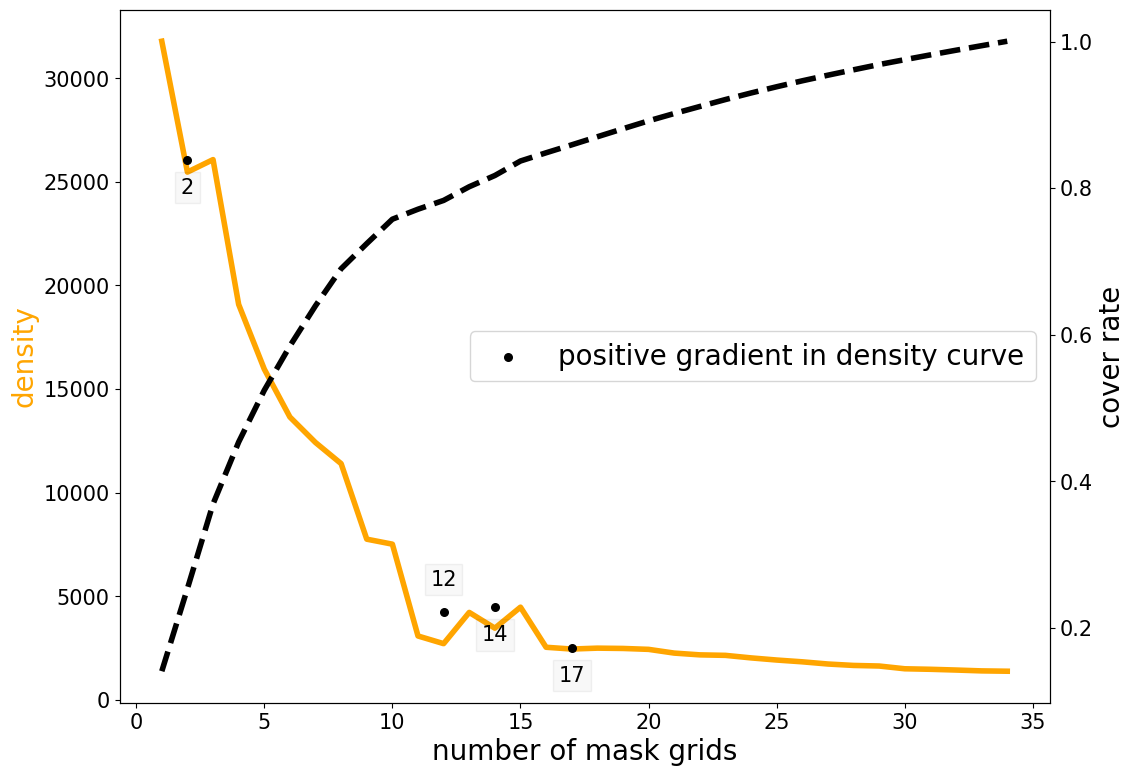

In [7]:
density_trace = load_dict['added_density']
cover_trace = load_dict['cover_rate']

xrange = np.arange(1, len(density_trace)+1)

back_index = []
for i in (xrange[:-1]):
    if density_trace[i] > density_trace[i-1]:
        back_index.append(i)
print(back_index)
back_density = [density_trace[b] for b in back_index]

plt.rcParams.update({'font.size': 15})
fig, ax1 = plt.subplots(figsize=(12, 9))

ax1.plot(xrange, density_trace, linewidth='4', color='orange')
ax1.scatter(back_index, back_density, color='black', s=30, label='positive gradient in density curve', zorder=2)
ax1.set_xlabel('number of mask grids', fontsize='20')
ax1.set_ylabel('density', color='orange', fontsize='20')
ax1.legend(loc='right', fontsize='20')

txt_height = 0.04 * (plt.ylim()[1] - plt.ylim()[0])
txt_width = 0.03 * (plt.xlim()[1] - plt.xlim()[0])
text_positions = get_text_positions(back_index, back_density, txt_width, txt_height)
for xi, yi in zip(back_index, text_positions):
    ax1.text(xi, yi, xi, ha='center', va='center', bbox=dict(facecolor='gray', alpha=0.05))

ax2 = ax1.twinx()
ax2.plot(xrange, cover_trace, linestyle='--', linewidth='4', color='black', zorder= 0.5)
ax2.set_ylabel('cover rate', color='black', fontsize='20')
plt.show()

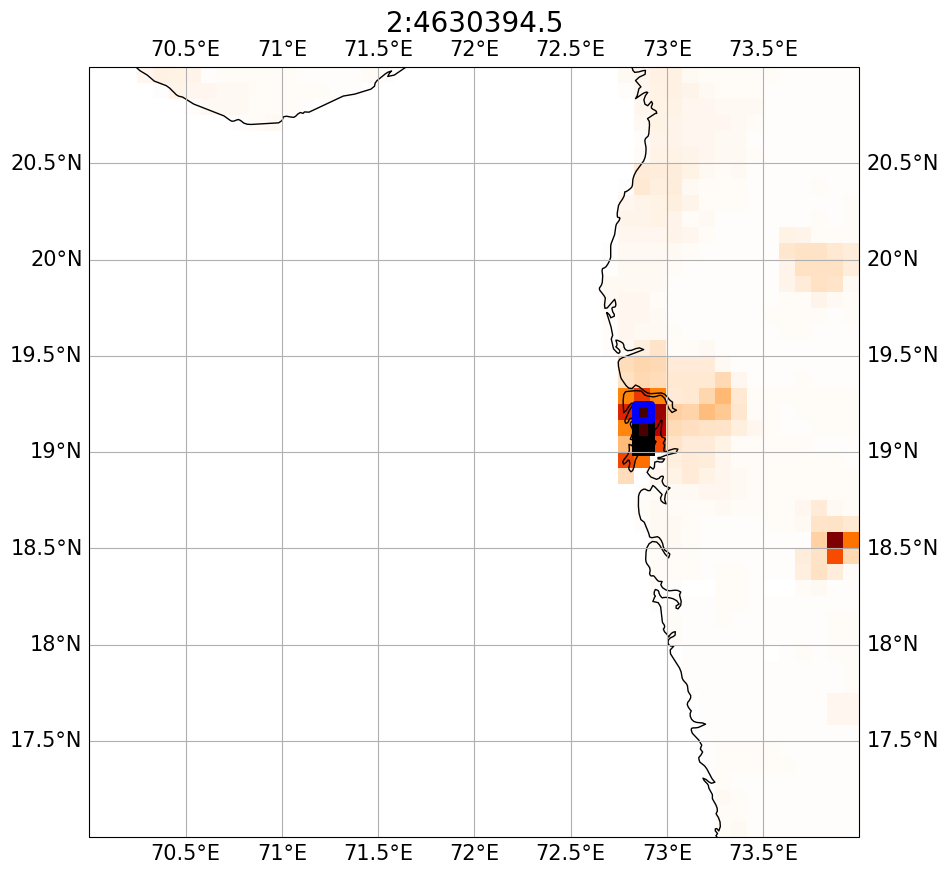

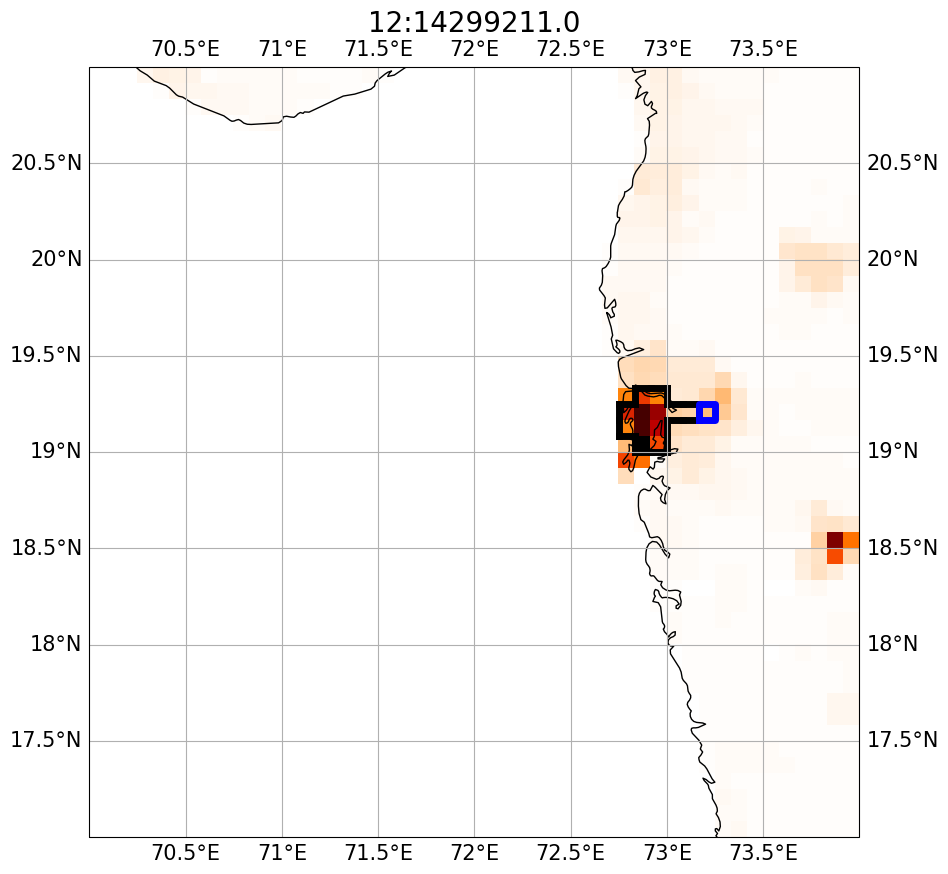

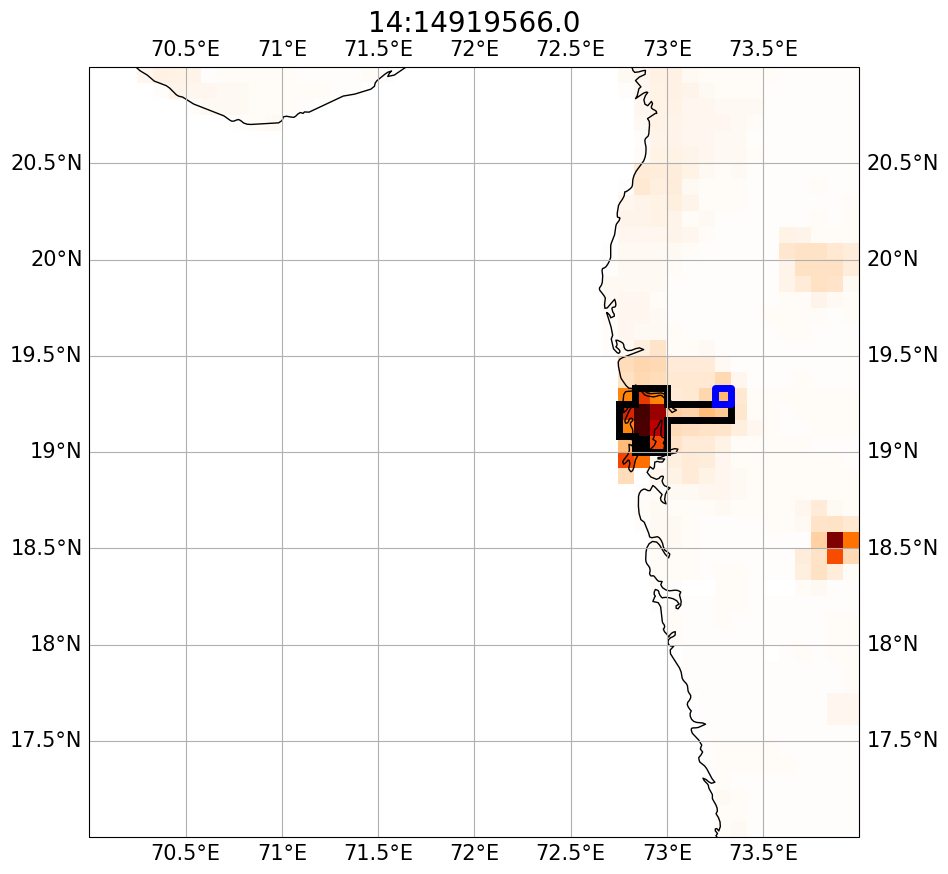

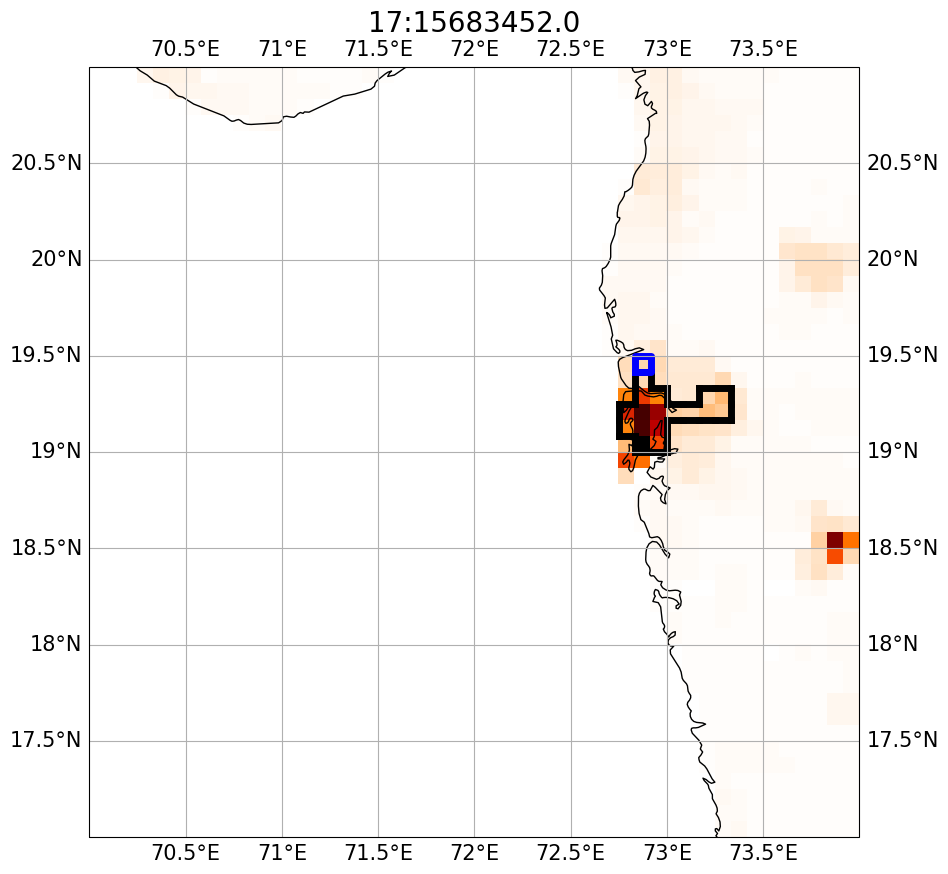

In [8]:
bestmask_trace = load_dict['mask']
density_trace = load_dict['added_density']
nextdensity_trace = load_dict['next_density']
totalpop_trace = load_dict['masked_population']
coverage_trace = load_dict['cover_rate']
nextcoords_trace = load_dict['next_coords']
un_pop = load_dict['un_population']
#gwp_pop_density = load_dict['population_density']

gpw_path = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city/dat/pop_tot_/GPW4ag__20100000.gl5'
gpw_pop = np.fromfile(gpw_path, dtype='float32').reshape(2160, 4320)
gwp_pop_density = gpw_pop

for mask_num in back_index:
    mask_tmp = bestmask_trace[:, :, mask_num-1]
    prv = density_trace[mask_num-1]
    nxt = nextdensity_trace[mask_num-1]
    pop = totalpop_trace[mask_num-1]
    cov = coverage_trace[mask_num-1]
    cor = nextcoords_trace[mask_num-1]
    title = f'{mask_num}:{pop}'
    
    draw_mask(mask_tmp, gwp_pop_density, city_index, np.round(prv), np.round(nxt), pop, un_pop, cov, cor, title)

In [22]:
# 保存する方法
#selected_num = 33

#rootdir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat'
#mask_file = f'{rootdir}/cty_msk_/city_kj_{city_index:08}.gl5'
#modified_mask = bestmask_trace[:, :, selected_num-1]
#modified_mask.astype(np.float32).tofile(mask_file)

In [20]:
def check_dwn(mask_temp, pop_temp, city_index, loop_num, maximum_value, best_masked_pop, un_pop, best_coverage, density_ratio):
    upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)
    # crop
    mask_cropped = mask_temp[upperindex:lowerindex, leftindex:rightindex]
    
    # pop
    pop_cropped = pop_temp[upperindex:lowerindex, leftindex:rightindex]
    
    # delta
    delta = 360/4320
    x_left = img_extent[0]
    y_top = img_extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows):
        for j in range(cols):
            if mask_cropped[i, j] == 1:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))
                    
    # extent
    projection = ccrs.PlateCarree()

    # figure
    fig = plt.figure(figsize=(10,10))
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    ax.set_extent(img_extent)
    ax.gridlines(draw_labels=True)
    
    im = ax.imshow(pop_cropped,
                   origin='upper',extent=img_extent, transform=projection, cmap='gist_heat_r'
                  )
    
    # city mask
    sotowaku_color = 'blue'
    linewidth = 3
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth) # right
    #
    #seethrough = np.ma.masked_where(mask_cropped == 0, mask_cropped)
    #seethrough[-1, -1] = 0
    #im2 = ax.imshow(seethrough,
    #                origin='upper',extent=img_extent, transform=projection, cmap='gray_r'
    #               )
    # 
    title = np.sum(mask_temp)
    plt.title(f"population density: {maximum_value} [/km2]\ndensity ratio: {density_ratio}[%]\ncoverage: {int(best_masked_pop)}/{int(un_pop)}[person]\ncoverage rate: {np.round(best_coverage*100,2)}[%]\nloop_num:{title}")
    plt.show()
    
def xy2lonlat(x, y):
    a, b = 2160, 4320
    
    if 0 <= x <= b:
        loncnt = (x*360/b)-180
        latcnt = 90 - (y*180)/a
    else:
        loncnt = 1e20
        latcnt = 1e20
    
    return loncnt, latcnt
    
def explore_citymask(index):

    #-----------------------------------------------
    # PATHS
    #-----------------------------------------------

    # pop data
    POP='gpw4'

    # map data
    MAP='CAMA'

    # path
    h08dir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
    camadir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity'
    city_path = f'{h08dir}/dat/cty_lst_/{POP}/WUP2018_300k_2010.txt'

    #####################################################################################################
    # CAMAのlnd_ara_だと海陸分布がGPWと一致していないくて，人が海に落ちてしまう
    # 花崎さんのgrd_araの方法で入力した場合は，沿岸域が無限に広がっていってしまう可能性がある
    # 那覇とか台湾がNoMASKのなっている理由も沿岸域のバグが関係しているかも
    # 一方で，人口区分としては正しく抜き出せていたとしても，CAMAの河川網と比較する場合に，海陸マップの不整合が発生すると思われる
    # またDOMESTICとINDUSTRYの需要量を計算するときに過小評価が発生する問題をのちの水資源評価で解決する必要がある
    area_path = f'{camadir}/dat/grd_ara_/grdara.gl5'

    # areaを変更した方法で1860都市を探索しなおした場合に，1553都市以上が探索される可能性があるので，その検証を別ディレクトリで行う
    #####################################################################################################
    
    pop_path = f'{h08dir}/dat/pop_tot_/GPW4ag__20100000.gl5'
    center_path = f'{h08dir}/dat/cty_cnt_/{POP}/city_{index:08d}.gl5'
    
    #-----------------------------------------------
    # Input Constants
    #-----------------------------------------------

    # search radius (1grid in 0.5degree)
    circle = 1

    # EN.1: lower limitation of population density
    lowlim = 100
    
    # EN.2: initial grid threshold
    threshold = 100
    
    # EN.3: grid sum
    grdlim = 3
    
    # EN.3: downtown rate
    downtown_rate = 1.5

    # EN.4: lowest rate
    lowrat = 0.0

    # shape
    lat_shape = 2160
    lon_shape = 4320

    # date type
    dtype= 'float32'

    #-----------------------------------------------
    # Initialization
    #-----------------------------------------------
    
    # initialize variables
    best_coverage = float('inf')
    best_mask = None
    best_masked_pop = None

    #-----------------------------------------------
    # load true data (UN city list) unit=[1000person]
    #-----------------------------------------------

    # true population and city name
    un_pop_list = []
    name_list = []

    # load data
    for l in open(city_path).readlines():
        data = l[:].split('\t')
        data = [item.strip() for item in data]
        un_pop_list.append(float(data[3]))
        name_list.append(data[4])

    # get true UN city population
    un_pop = un_pop_list[index-1]*1000

    # get city name
    city_name = name_list[index-1]

    #-----------------------------------------------
    #  Get area(m2)
    #-----------------------------------------------

    area = np.fromfile(area_path, dtype=dtype).reshape(lat_shape, lon_shape)

    #-----------------------------------------------
    # load gwp population data
    #-----------------------------------------------

    # population data(GWP4 2000)
    gwp_pop = np.fromfile(pop_path, dtype=dtype).reshape(lat_shape, lon_shape)

    # population density (person/km2)
    gwp_pop_density = (gwp_pop / (area / 10**6))

    #-----------------------------------------------
    # load city_center coordinate
    #-----------------------------------------------

    location = np.fromfile(center_path, dtype=dtype).reshape(lat_shape,lon_shape)
    org_y = np.where(location==1)[0]
    org_x = np.where(location==1)[1]
    org_y = org_y[0]
    org_x = org_x[0]
    
    #-----------------------------------------------
    # check city center
    #-----------------------------------------------

    # original city center
    org_cnt = gwp_pop_density[org_y, org_x]

    # number of replacement
    print(f"cityindex {index}")
    org_lon, org_lat = xy2lonlat(org_x, org_y)
    print(f'original center [x, y] = [{org_lon, org_lat}]')
    print(f'org_cnt: {org_cnt}')
    
    for a_cnt in range(org_y-circle, org_y+circle+1):
        for b_cnt in range(org_x-circle, org_x+circle+1):
            candidate = gwp_pop_density[a_cnt, b_cnt]
            if candidate >= org_cnt:
                org_cnt = candidate
                rpl_y = a_cnt
                rpl_x = b_cnt
                
    new_lon, new_lat = xy2lonlat(rpl_x, rpl_y)
    print(f'replaced center [x, y] = [{new_lon, new_lat}]')
    print(f"rpl_cnt: {gwp_pop_density[rpl_y, rpl_x]}")

    #-----------------------------------------------
    #  Initialization of mask array
    #-----------------------------------------------

    # mask array for saving
    mask = np.zeros((lat_shape,lon_shape), dtype=dtype)
    mask[rpl_y, rpl_x] = 1
    
    #-----------------------------------------------
    #  Density trace
    #-----------------------------------------------

    density_trace = []

    #-----------------------------------------------
    #  Explore start
    #-----------------------------------------------

    # stop flag
    new_mask_added = True
    coverage_flag = True

    # city center
    best_mask = mask
    grid_num = np.sum(best_mask)
    best_masked_pop = np.sum(gwp_pop*mask)
    best_coverage = float(best_masked_pop / un_pop)

    # monitor density ration
    init_masked_dns = np.sum(gwp_pop_density[rpl_y, rpl_x])
    previous_density = np.sum(gwp_pop_density[rpl_y, rpl_x])
    density_trace.append(init_masked_dns)
    #print(density_trace)

    # initial grid threshold
    if gwp_pop_density[rpl_y, rpl_x] <= threshold:
        print("/// stop ///")
        print("/// stop ///")
        print(f"initial density {gwp_pop_density[rpl_y, rpl_x]} less than threshold {threshold}")
        print("/// stop ///")
        print("/// stop ///")
        new_mask_added = False
        coverage_flag = False
        loop_num = 1
        next_density = gwp_pop_density[rpl_y, rpl_x]
        density_ratio = 0
        check_dwn(best_mask, gwp_pop_density, index, loop_num, np.round(next_density), best_masked_pop, un_pop, best_coverage, density_ratio)

    # loop start
    loop_num = 0
    while new_mask_added:

        ### make search list
        search_lst = []
        new_mask_added = False
        indices = np.where(mask == 1)

        for ind in range(len(indices[0])):
            y_index = indices[0][ind]
            x_index = indices[1][ind]
            for dx, dy in [(-1, 0), (0, 1), (1, 0), (0, -1)]:
                i = y_index + dy
                j = x_index + dx
                # not explored yet
                if mask[i, j] == 0:
                    # within grid range
                    if 0 <= i < lat_shape and 0<= j < lon_shape:
                        search_lst.append([gwp_pop_density[i, j], i, j])
                        
        ### add searched grid
        # empty check
        if not search_lst:

            print('search_lst is empty')
            new_mask_added = False
            coverage_flag = False
            
        # get largest grid
        else:
            
            sorted_search = sorted(search_lst, key=lambda x: x[0], reverse=True)
            largest = sorted_search[0]
            next_density = gwp_pop_density[largest[1], largest[2]]
            density_ratio = int((next_density/init_masked_dns)*100)
            
            # if largest grid value is too small, stop exploring
            if next_density <= lowlim:
                print("/// stop ///")
                print("/// stop ///")
                print(f"largest density {gwp_pop_density[largest[1], largest[2]]} smaller than lowlim {lowlim}")
                print([gwp_pop_density[t[1], t[2]]for t in sorted_search])
                print("/// stop ///")
                print("/// stop ///")
                new_mask_added = False
                coverage_flag = False
                
            elif next_density > previous_density and best_coverage > downtown_rate and grid_num >= grdlim:
                print("/// stop ///")
                print("/// stop ///")
                print(f"latest density {next_density} bigger than previous density {previous_density}")
                print("/// stop ///")
                print("/// stop ///")
                new_mask_added = False
                coverage_flag = False
                
            elif density_ratio < lowrat:
                print("/// stop ///")
                print("/// stop ///")
                print(f"latest density {next_density} less than 1/{lowrat} of initial density {init_masked_dns}")
                print("/// stop ///")
                print("/// stop ///")
                new_mask_added = False
                coverage_flag = False
                
        # stop flag
        if coverage_flag is True:
                new_mask_added = True

                # evaluate coverage
                gwp_masked_pop = np.sum(mask * gwp_pop)
                coverage = float(gwp_masked_pop / un_pop)

                # stop exploring
                if coverage >= 1.0:
                    new_mask_added = False
                    coverage_flag = False

                # judge
                judge_value = abs(1 - coverage)
                best_value = abs(1 - best_coverage)
            
                # update
                if judge_value < best_value:
                    best_coverage = coverage
                    best_mask = mask
                    best_masked_pop = gwp_masked_pop
                    grid_num = np.sum(best_mask)
                    previous_density = gwp_pop_density[largest[1], largest[2]]
                    
                # previous_density add
                density_trace.append(previous_density)
                #print(density_trace)


        if np.sum(best_mask) == 1:
            mask_track = best_mask
        else:
            mask_track = np.dstack((mask_track, best_mask))
        mask[largest[1], largest[2]] = 1
        
        # draw
        density_ratio = int((next_density/init_masked_dns)*100)
        check_dwn(best_mask, gwp_pop_density, index, loop_num, np.round(next_density), best_masked_pop, un_pop, best_coverage, density_ratio)
    
        upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)
        
        # loop count
        loop_num += 1

        #-----------------------------------------------
        # Output result
        #-----------------------------------------------

        print('#########################################')
        print(
              f"explored_pop {best_masked_pop}\n" \
              f"true_pop {un_pop}\n" \
              f"coverage {best_coverage}\n" \
              f"city_mask {grid_num}\n" \
              f"{city_name}"
              )
        print('#########################################')

    return density_trace, mask_track

cityindex 8
original center [x, y] = [(72.83333333333334, 19.08333333333333)]
org_cnt: 31786.839482556177
replaced center [x, y] = [(72.83333333333334, 19.08333333333333)]
rpl_cnt: 31786.839482556177


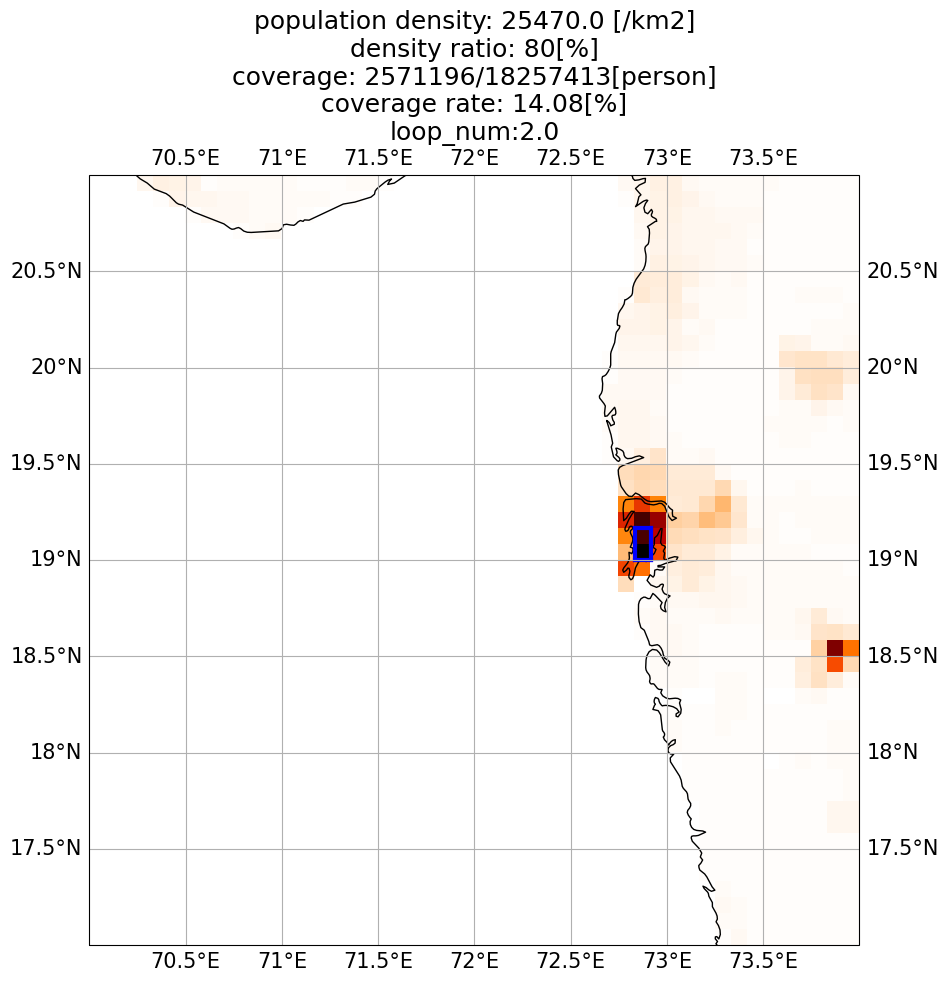

#########################################
explored_pop 2571196.25
true_pop 18257413.0
coverage 0.14083026165864793
city_mask 1.0
Mumbai (Bombay)
#########################################


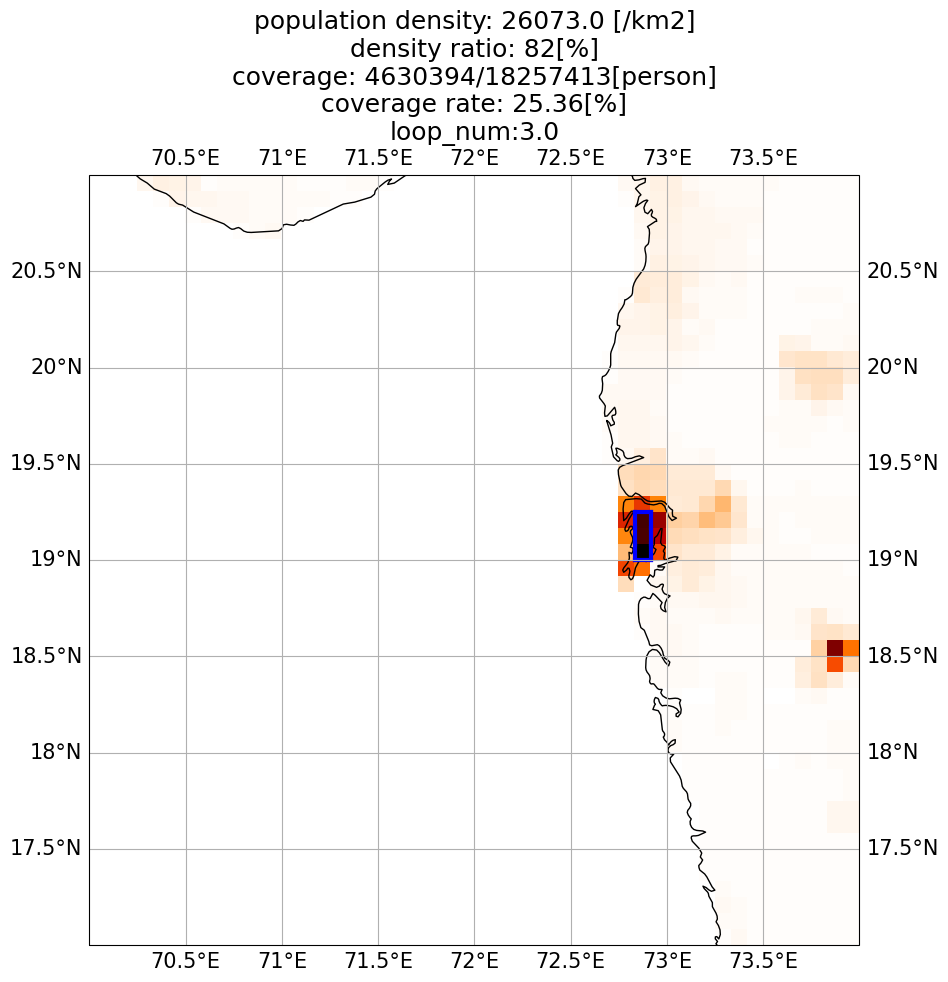

#########################################
explored_pop 4630394.5
true_pop 18257413.0
coverage 0.2536172293413092
city_mask 2.0
Mumbai (Bombay)
#########################################


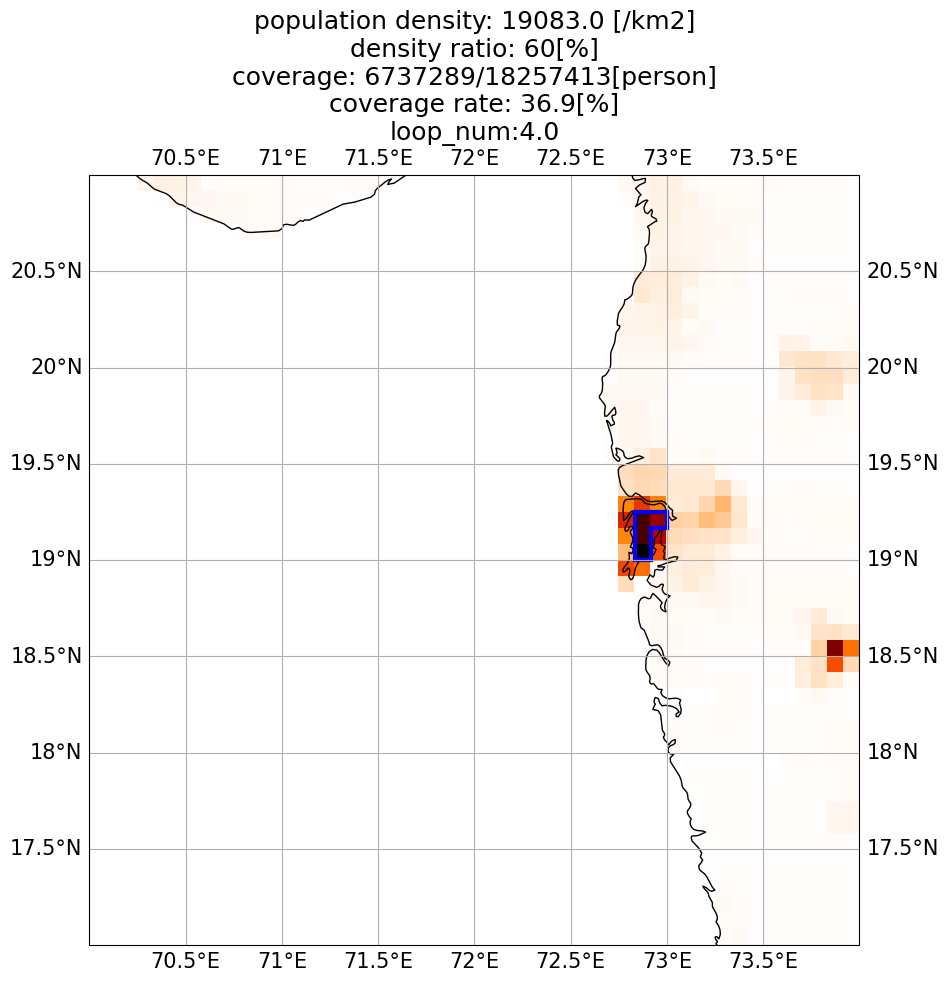

#########################################
explored_pop 6737289.0
true_pop 18257413.0
coverage 0.36901662902624816
city_mask 3.0
Mumbai (Bombay)
#########################################


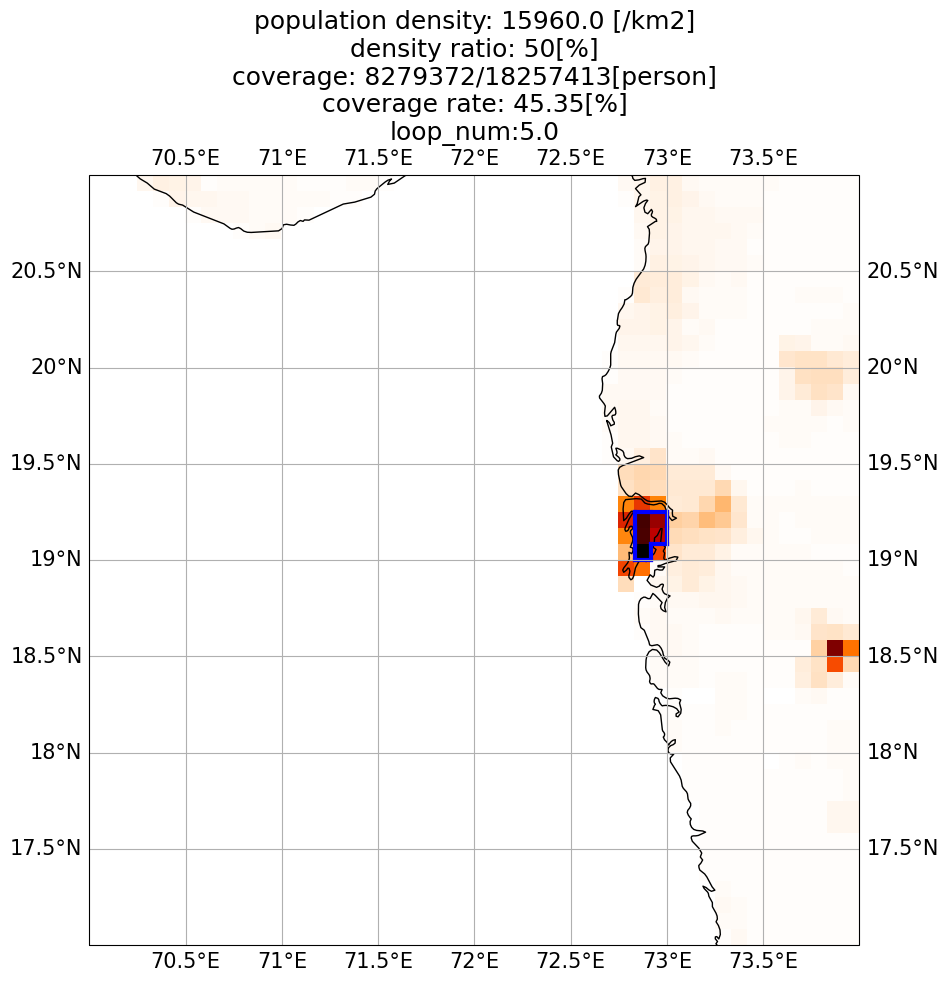

#########################################
explored_pop 8279372.0
true_pop 18257413.0
coverage 0.45348001932146687
city_mask 4.0
Mumbai (Bombay)
#########################################


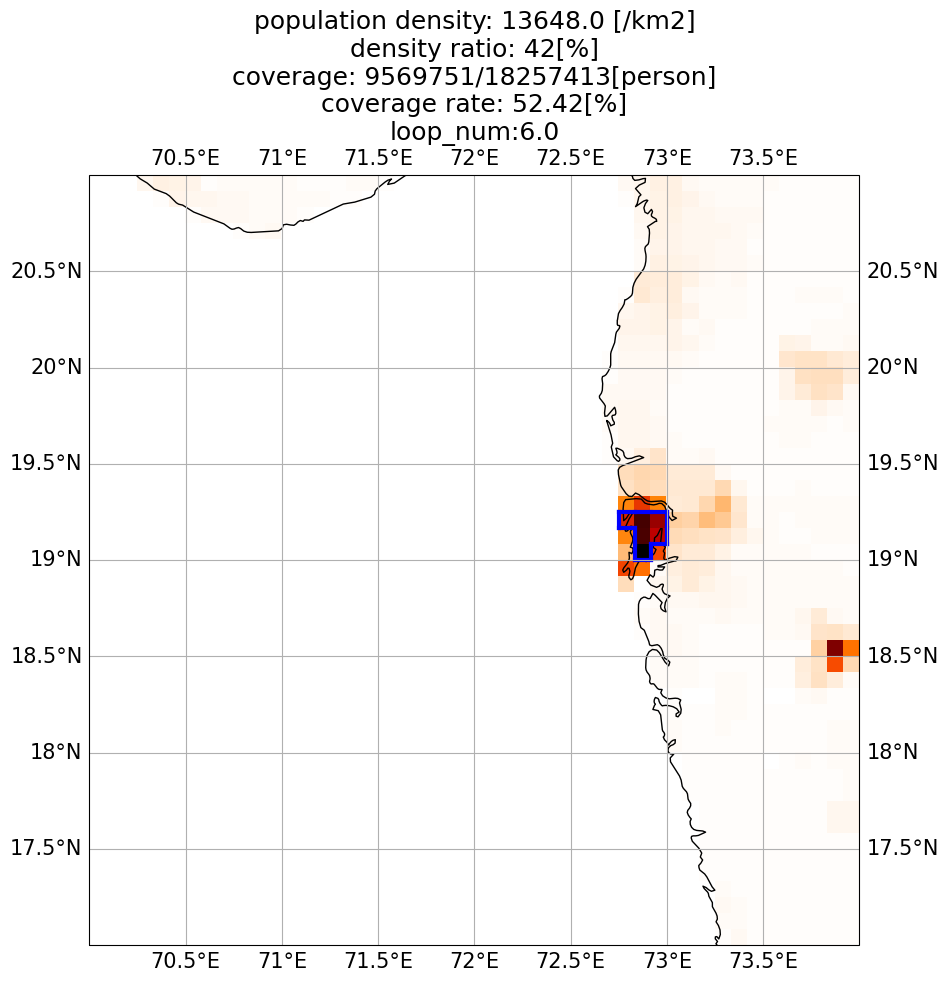

#########################################
explored_pop 9569751.0
true_pop 18257413.0
coverage 0.5241570095390842
city_mask 5.0
Mumbai (Bombay)
#########################################


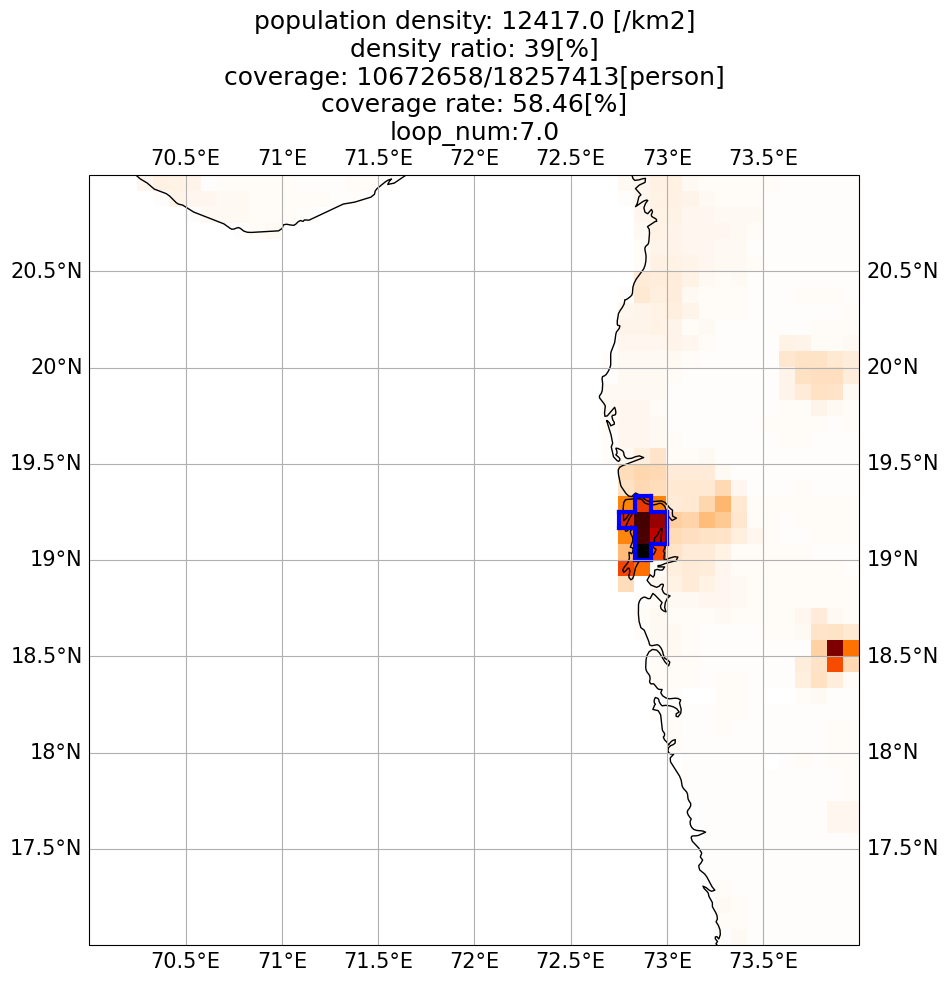

#########################################
explored_pop 10672658.0
true_pop 18257413.0
coverage 0.5845657322863869
city_mask 6.0
Mumbai (Bombay)
#########################################


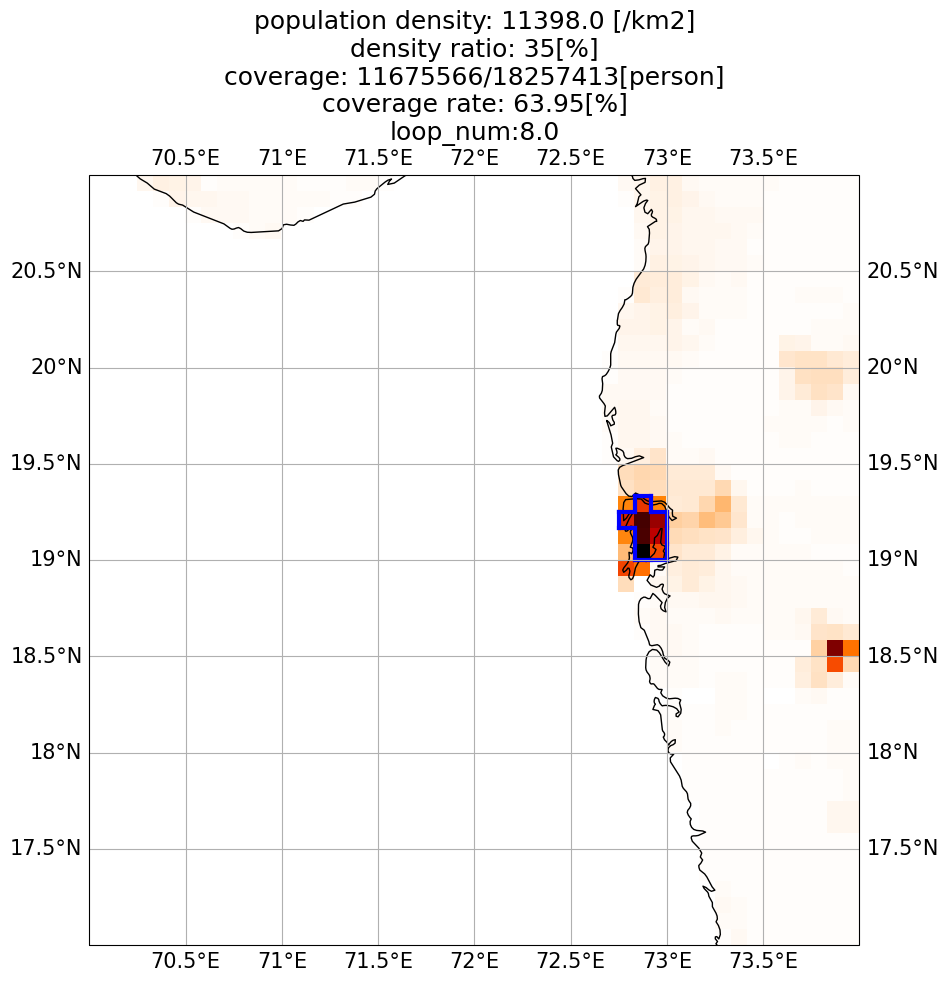

#########################################
explored_pop 11675566.0
true_pop 18257413.0
coverage 0.6394972825558582
city_mask 7.0
Mumbai (Bombay)
#########################################


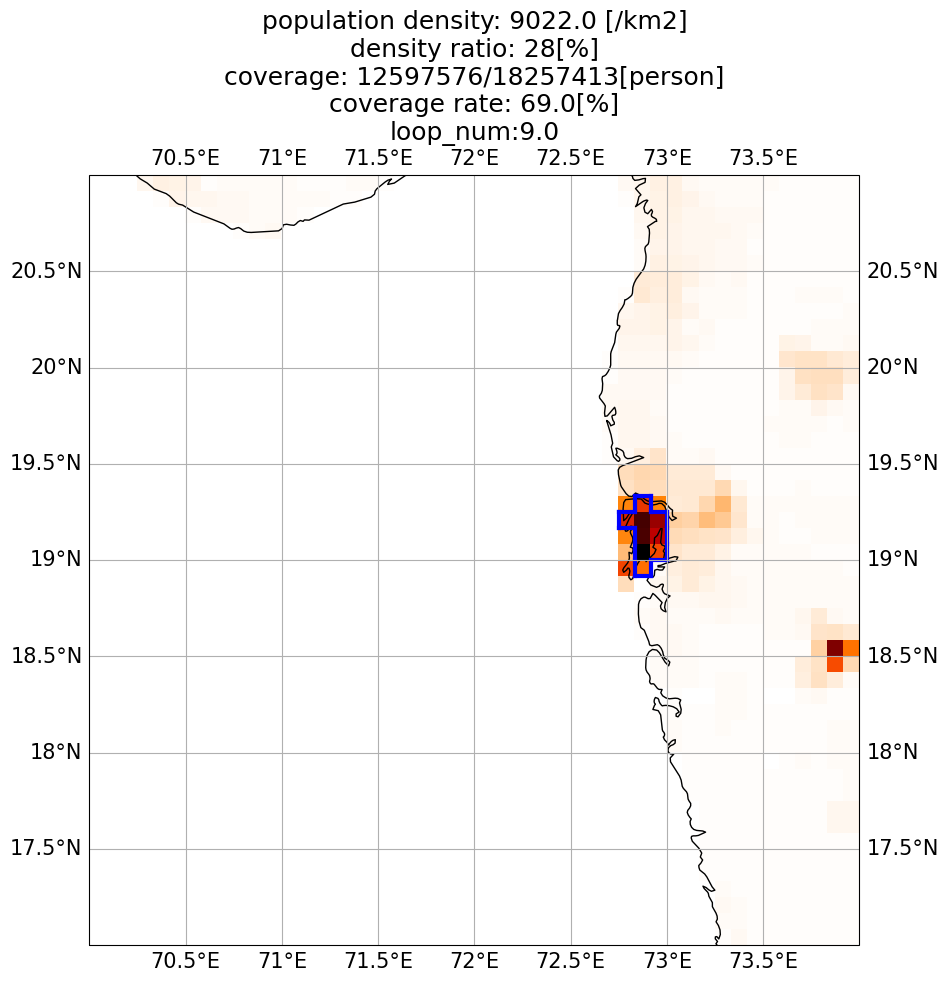

#########################################
explored_pop 12597576.0
true_pop 18257413.0
coverage 0.6899978655245407
city_mask 8.0
Mumbai (Bombay)
#########################################


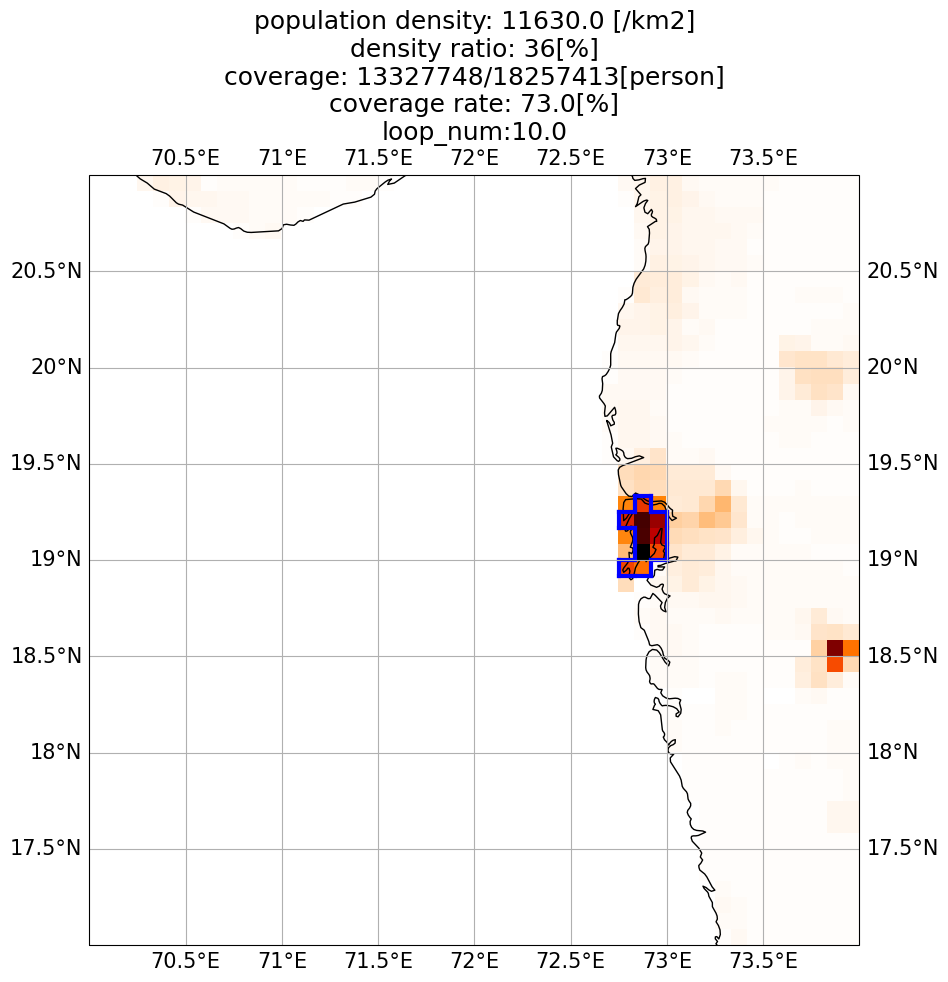

#########################################
explored_pop 13327748.0
true_pop 18257413.0
coverage 0.7299910452811688
city_mask 9.0
Mumbai (Bombay)
#########################################


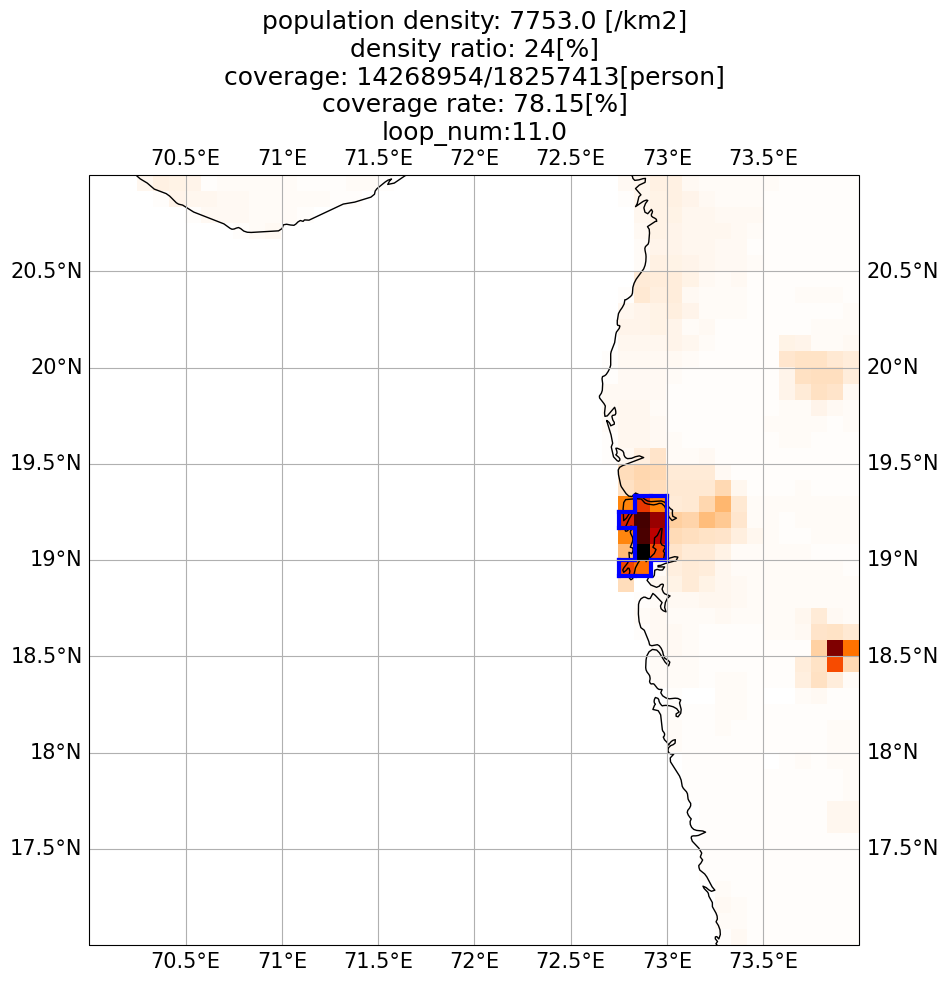

#########################################
explored_pop 14268954.0
true_pop 18257413.0
coverage 0.7815430367927811
city_mask 10.0
Mumbai (Bombay)
#########################################


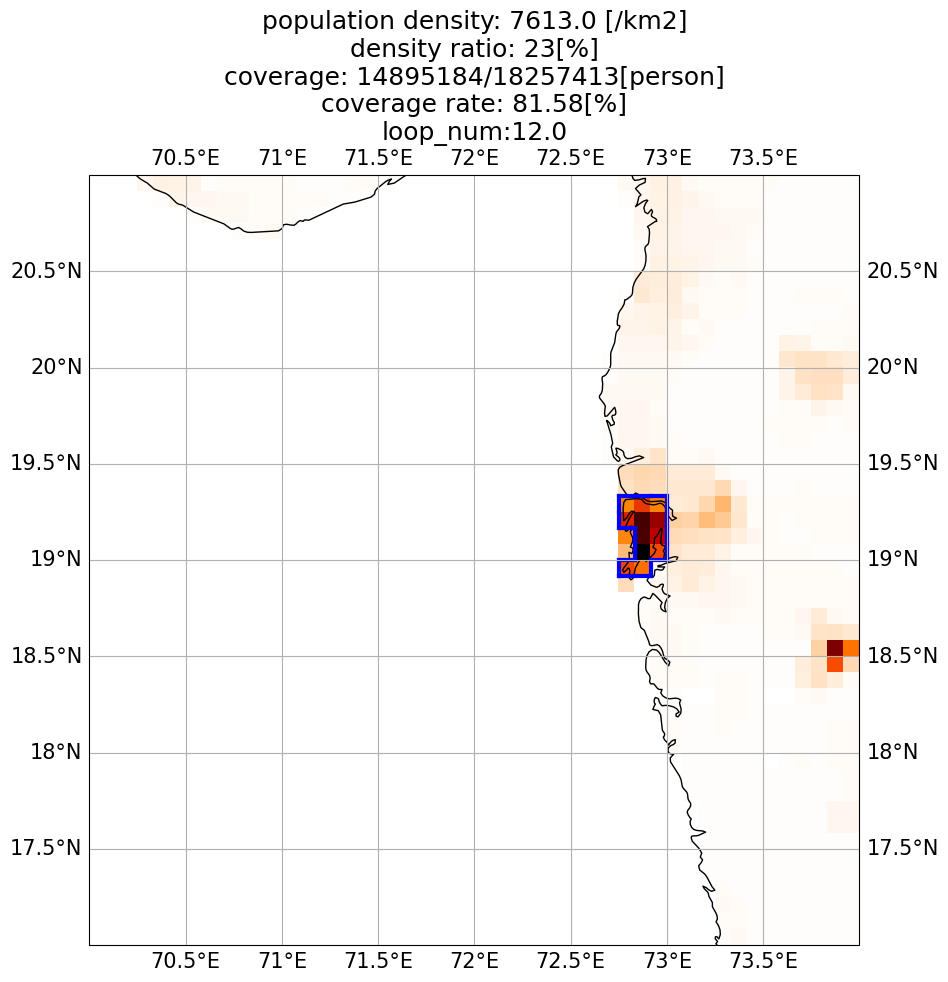

#########################################
explored_pop 14895184.0
true_pop 18257413.0
coverage 0.8158430770011064
city_mask 11.0
Mumbai (Bombay)
#########################################


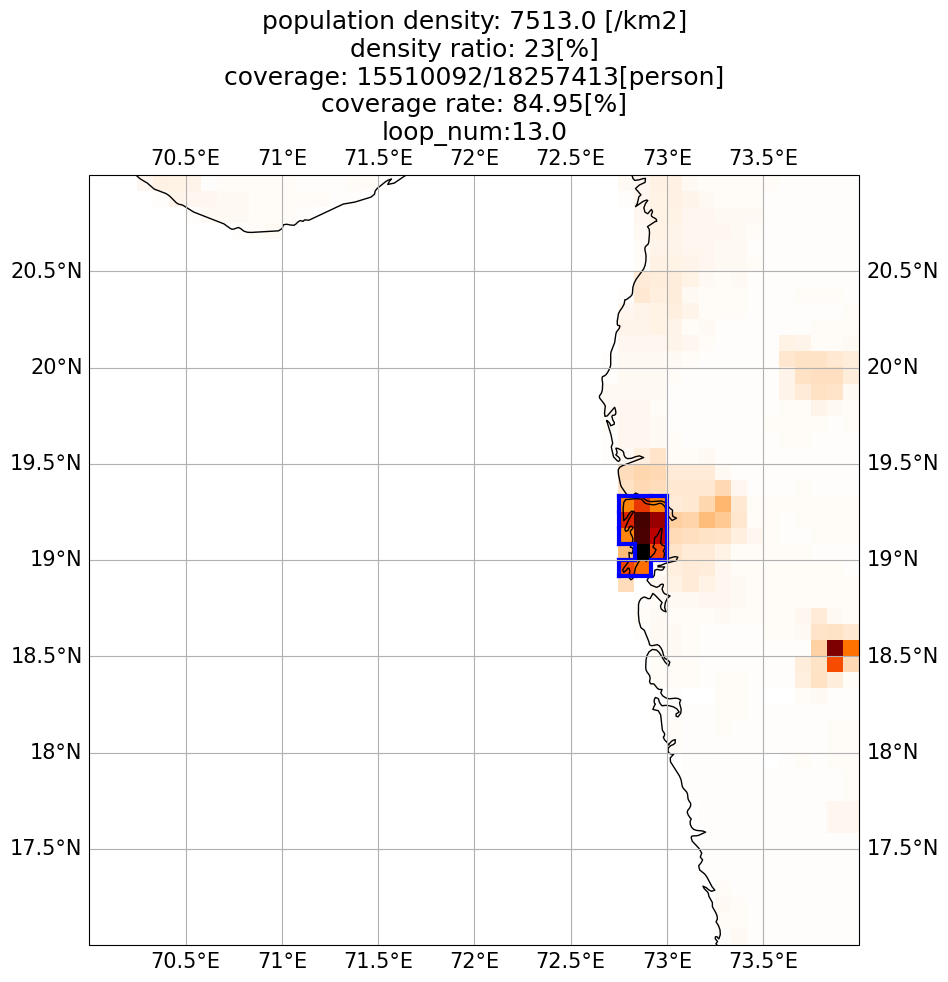

#########################################
explored_pop 15510092.0
true_pop 18257413.0
coverage 0.8495229855401748
city_mask 12.0
Mumbai (Bombay)
#########################################


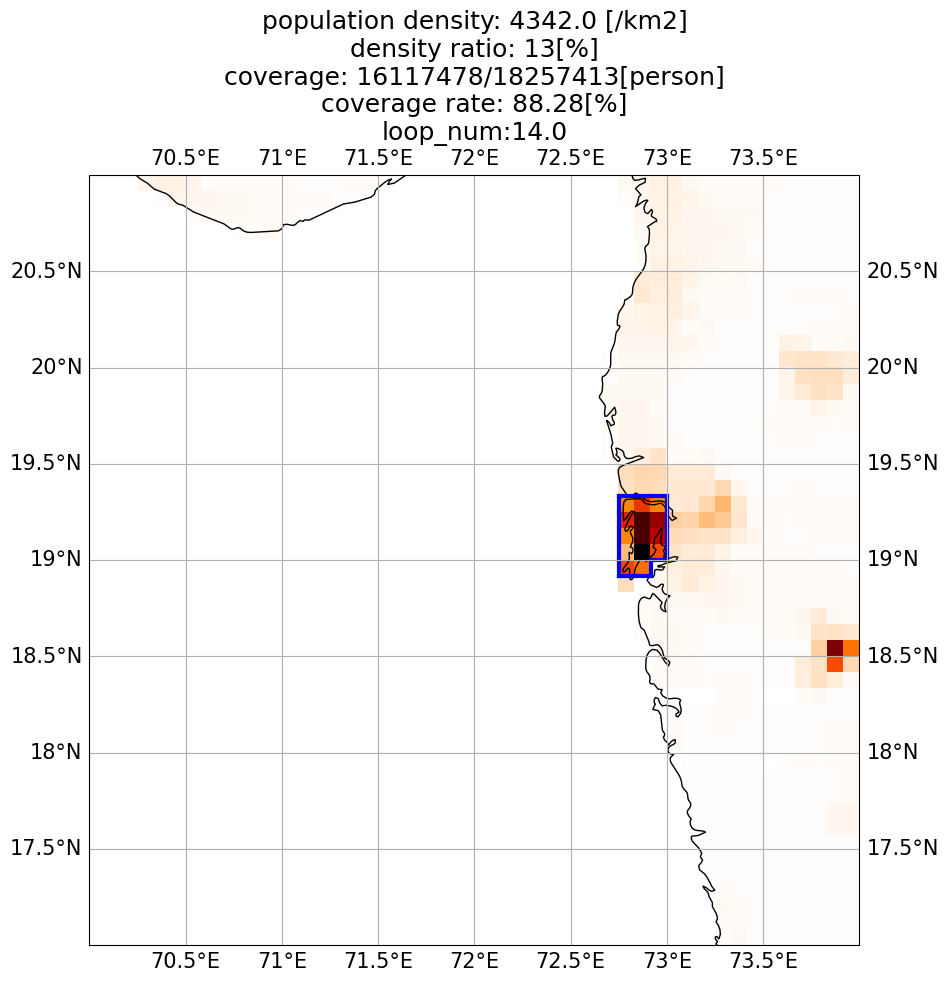

#########################################
explored_pop 16117478.0
true_pop 18257413.0
coverage 0.8827908970454905
city_mask 13.0
Mumbai (Bombay)
#########################################


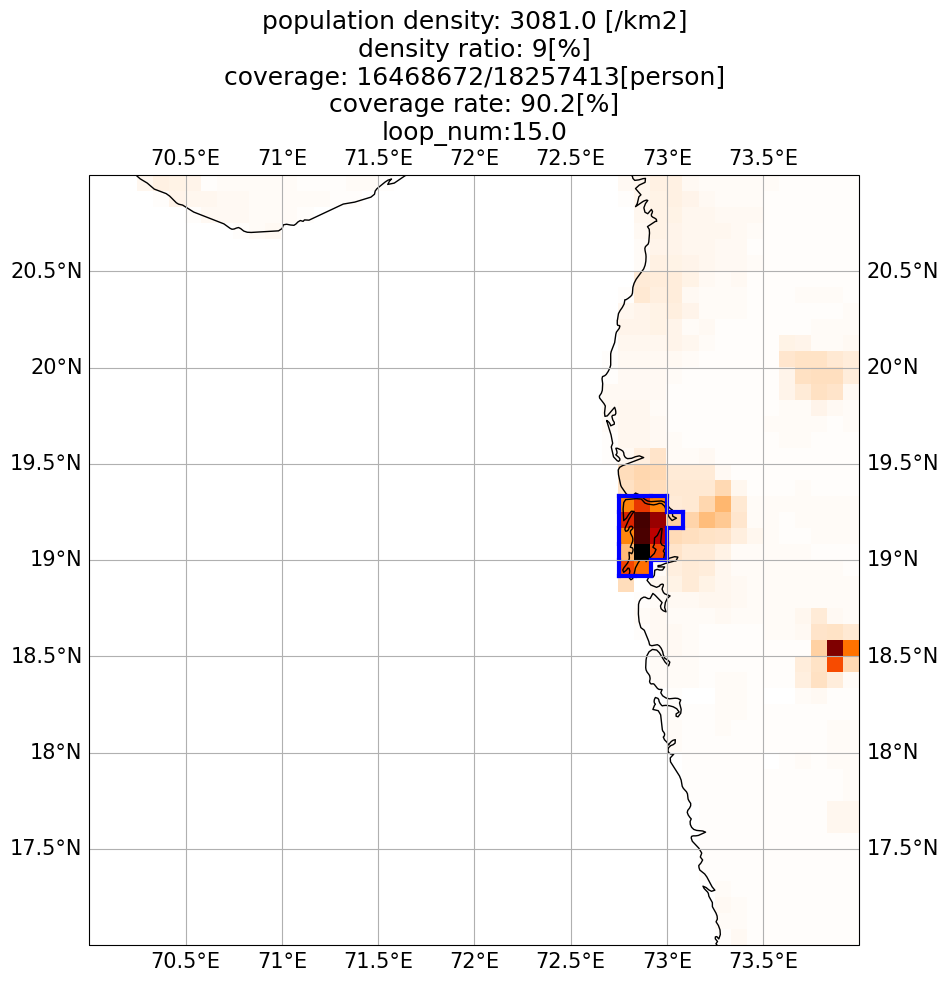

#########################################
explored_pop 16468672.0
true_pop 18257413.0
coverage 0.9020265905142202
city_mask 14.0
Mumbai (Bombay)
#########################################


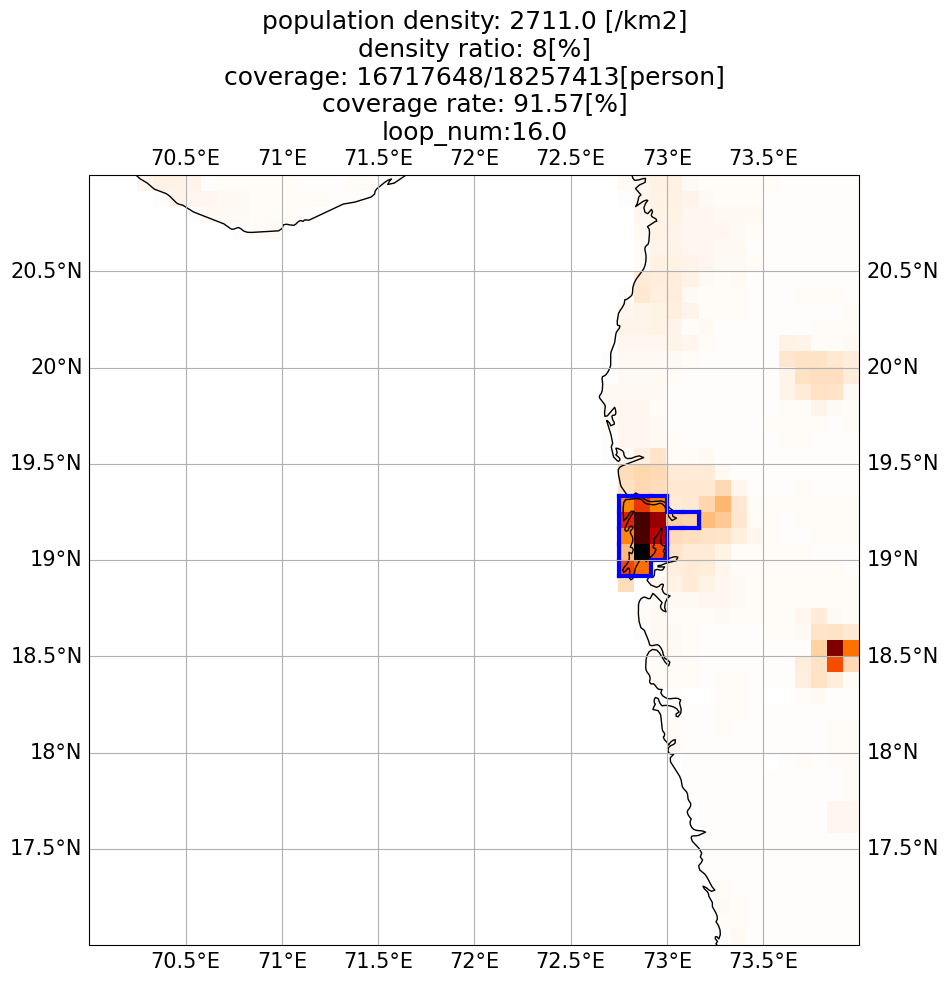

#########################################
explored_pop 16717648.0
true_pop 18257413.0
coverage 0.9156635718324387
city_mask 15.0
Mumbai (Bombay)
#########################################


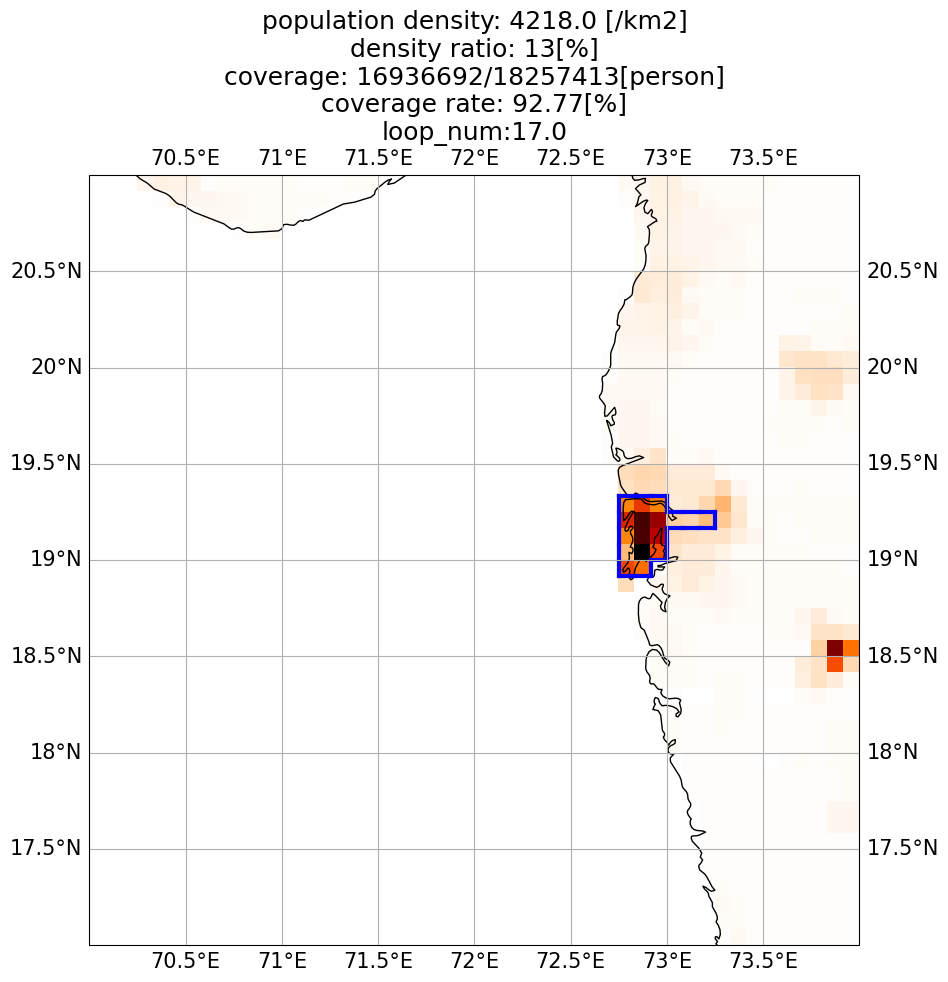

#########################################
explored_pop 16936692.0
true_pop 18257413.0
coverage 0.9276611094901561
city_mask 16.0
Mumbai (Bombay)
#########################################


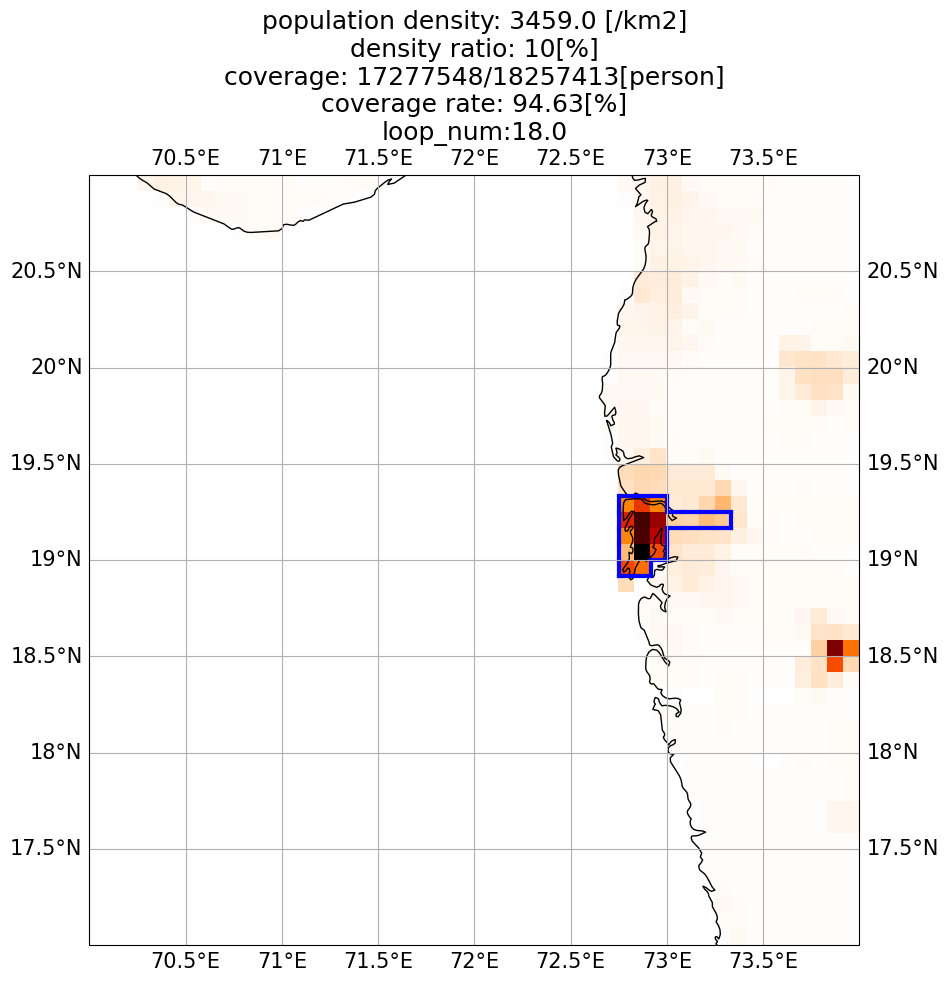

#########################################
explored_pop 17277548.0
true_pop 18257413.0
coverage 0.94633056720577
city_mask 17.0
Mumbai (Bombay)
#########################################


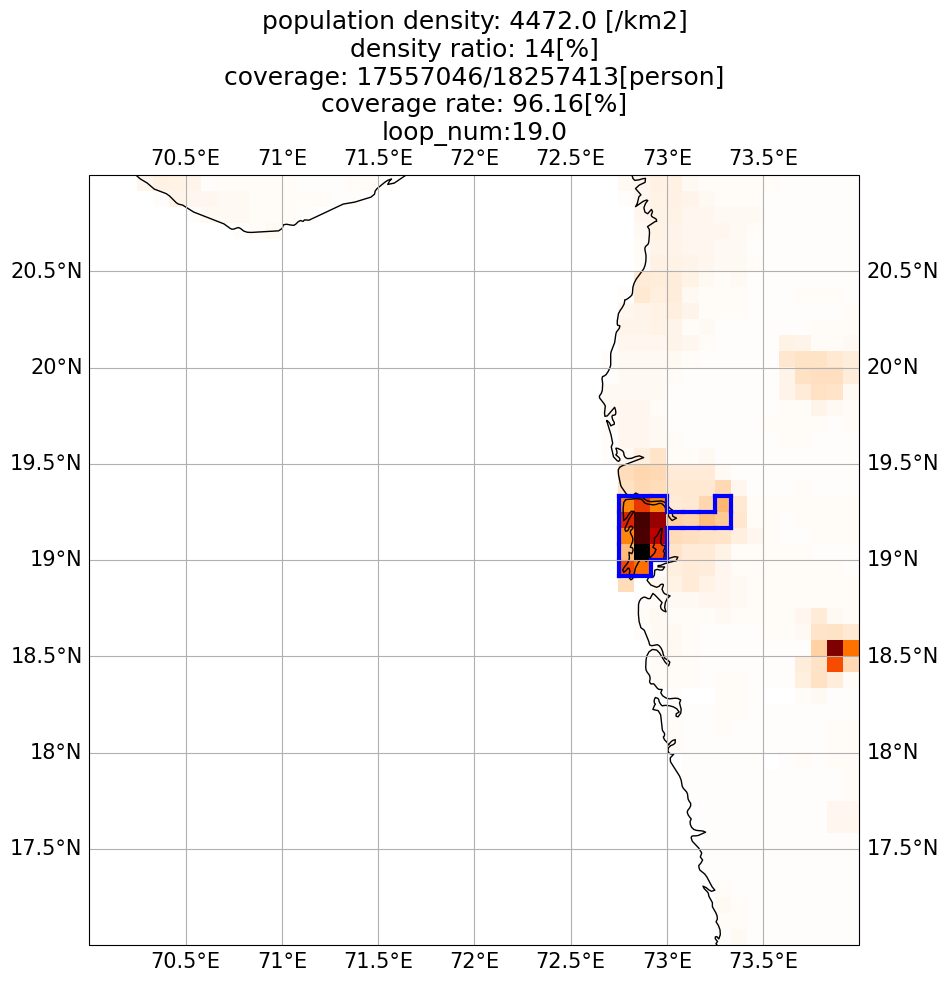

#########################################
explored_pop 17557046.0
true_pop 18257413.0
coverage 0.9616393078252653
city_mask 18.0
Mumbai (Bombay)
#########################################


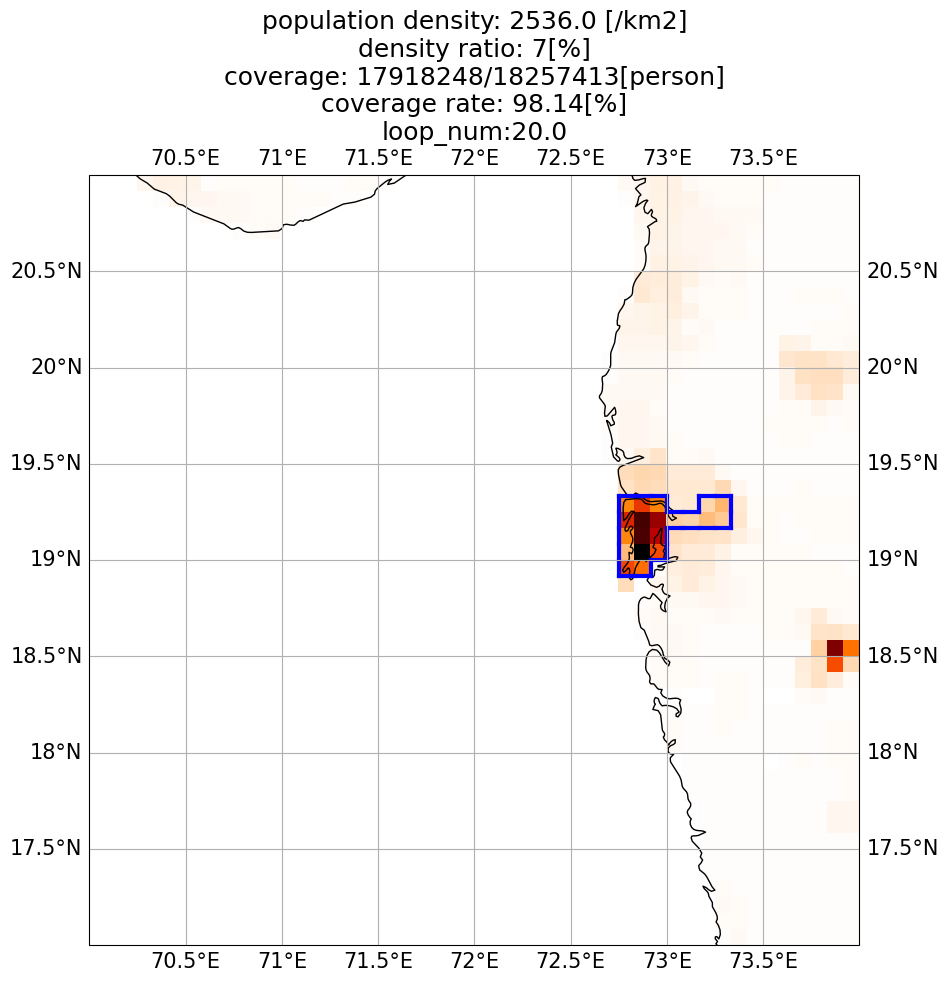

#########################################
explored_pop 17918248.0
true_pop 18257413.0
coverage 0.9814231621971853
city_mask 19.0
Mumbai (Bombay)
#########################################


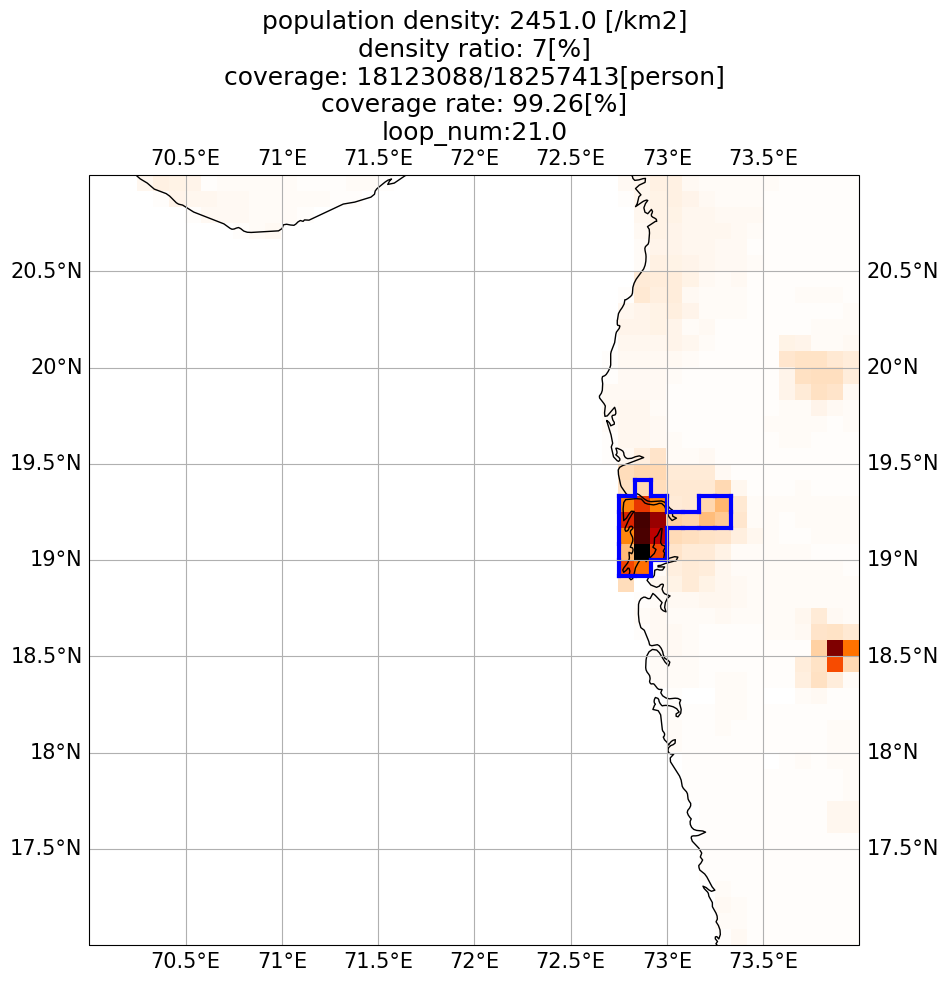

#########################################
explored_pop 18123088.0
true_pop 18257413.0
coverage 0.992642714496298
city_mask 20.0
Mumbai (Bombay)
#########################################


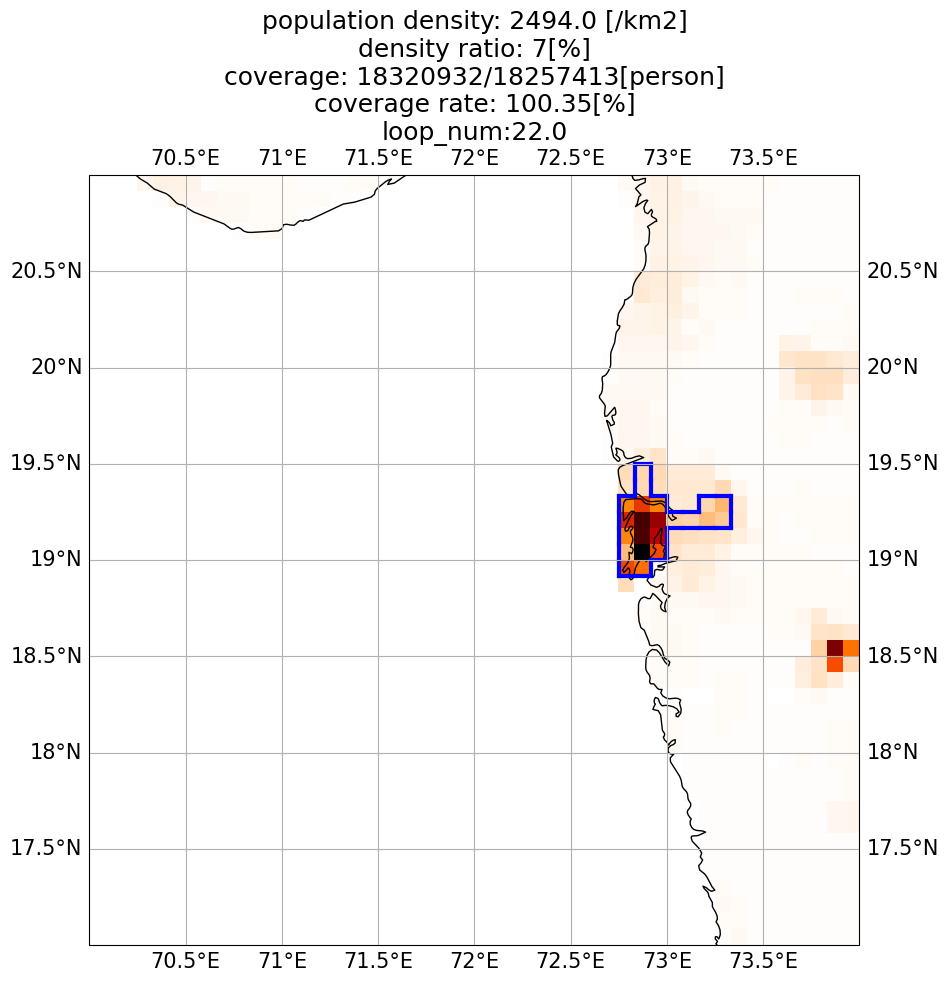

#########################################
explored_pop 18320932.0
true_pop 18257413.0
coverage 1.0034790799769935
city_mask 21.0
Mumbai (Bombay)
#########################################


In [21]:
upperindex, lowerindex, leftindex, rightindex, rgnshape, img_extent = geography(left, right, bottom, top)
density_trace, mask_track = explore_citymask(city_index)

In [22]:
# 保存する方法
selected_num = 13

rootdir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat'
mask_file = f'{rootdir}/cty_msk_/city_kj_{city_index:08}.gl5'
selected_mask = mask_track[:, :, selected_num-1]
selected_mask.astype(np.float32).tofile(mask_file)

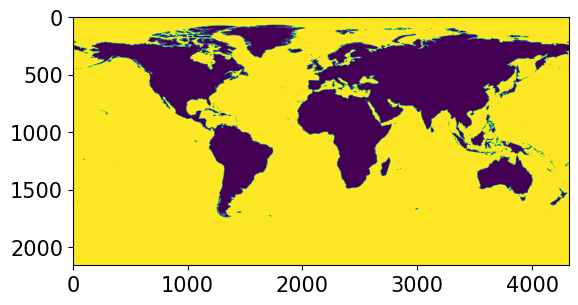

In [19]:
h08area_path = f'/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/grd_ara_/grdara.CAMA.gl5'
camaarea_path = f'{h08dir}/dat/lnd_ara_/lndara.CAMA.gl5'
tmp = np.fromfile(camaarea_path, dtype='float32').reshape(2160,4320)
plt.imshow(tmp)

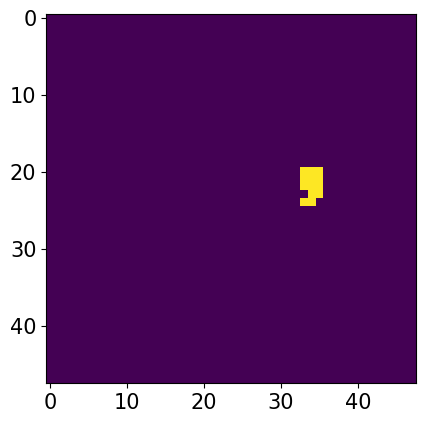

In [23]:
tmp2 = np.fromfile('/mnt/c/Users/tsimk/Downloads/dotfiles/h08/camacity/dat/cty_msk_/city_kj_00000008.gl5', dtype='float32').reshape(2160, 4320)
tmp2_cropped = tmp2[upperindex:lowerindex, leftindex:rightindex]
plt.imshow(tmp2_cropped)